# Attention

## 1.背景
- 在深度学习中，注意力是一种**信息筛选技术**，其灵感源于人类视觉/认知系统对关键信息的选择性关注。
- **核心思想**：根据输入的不同部分对当前任务的重要性，动态分配不同的权重。这种权重分配不是固定的，而是根据上下文动态计算的。
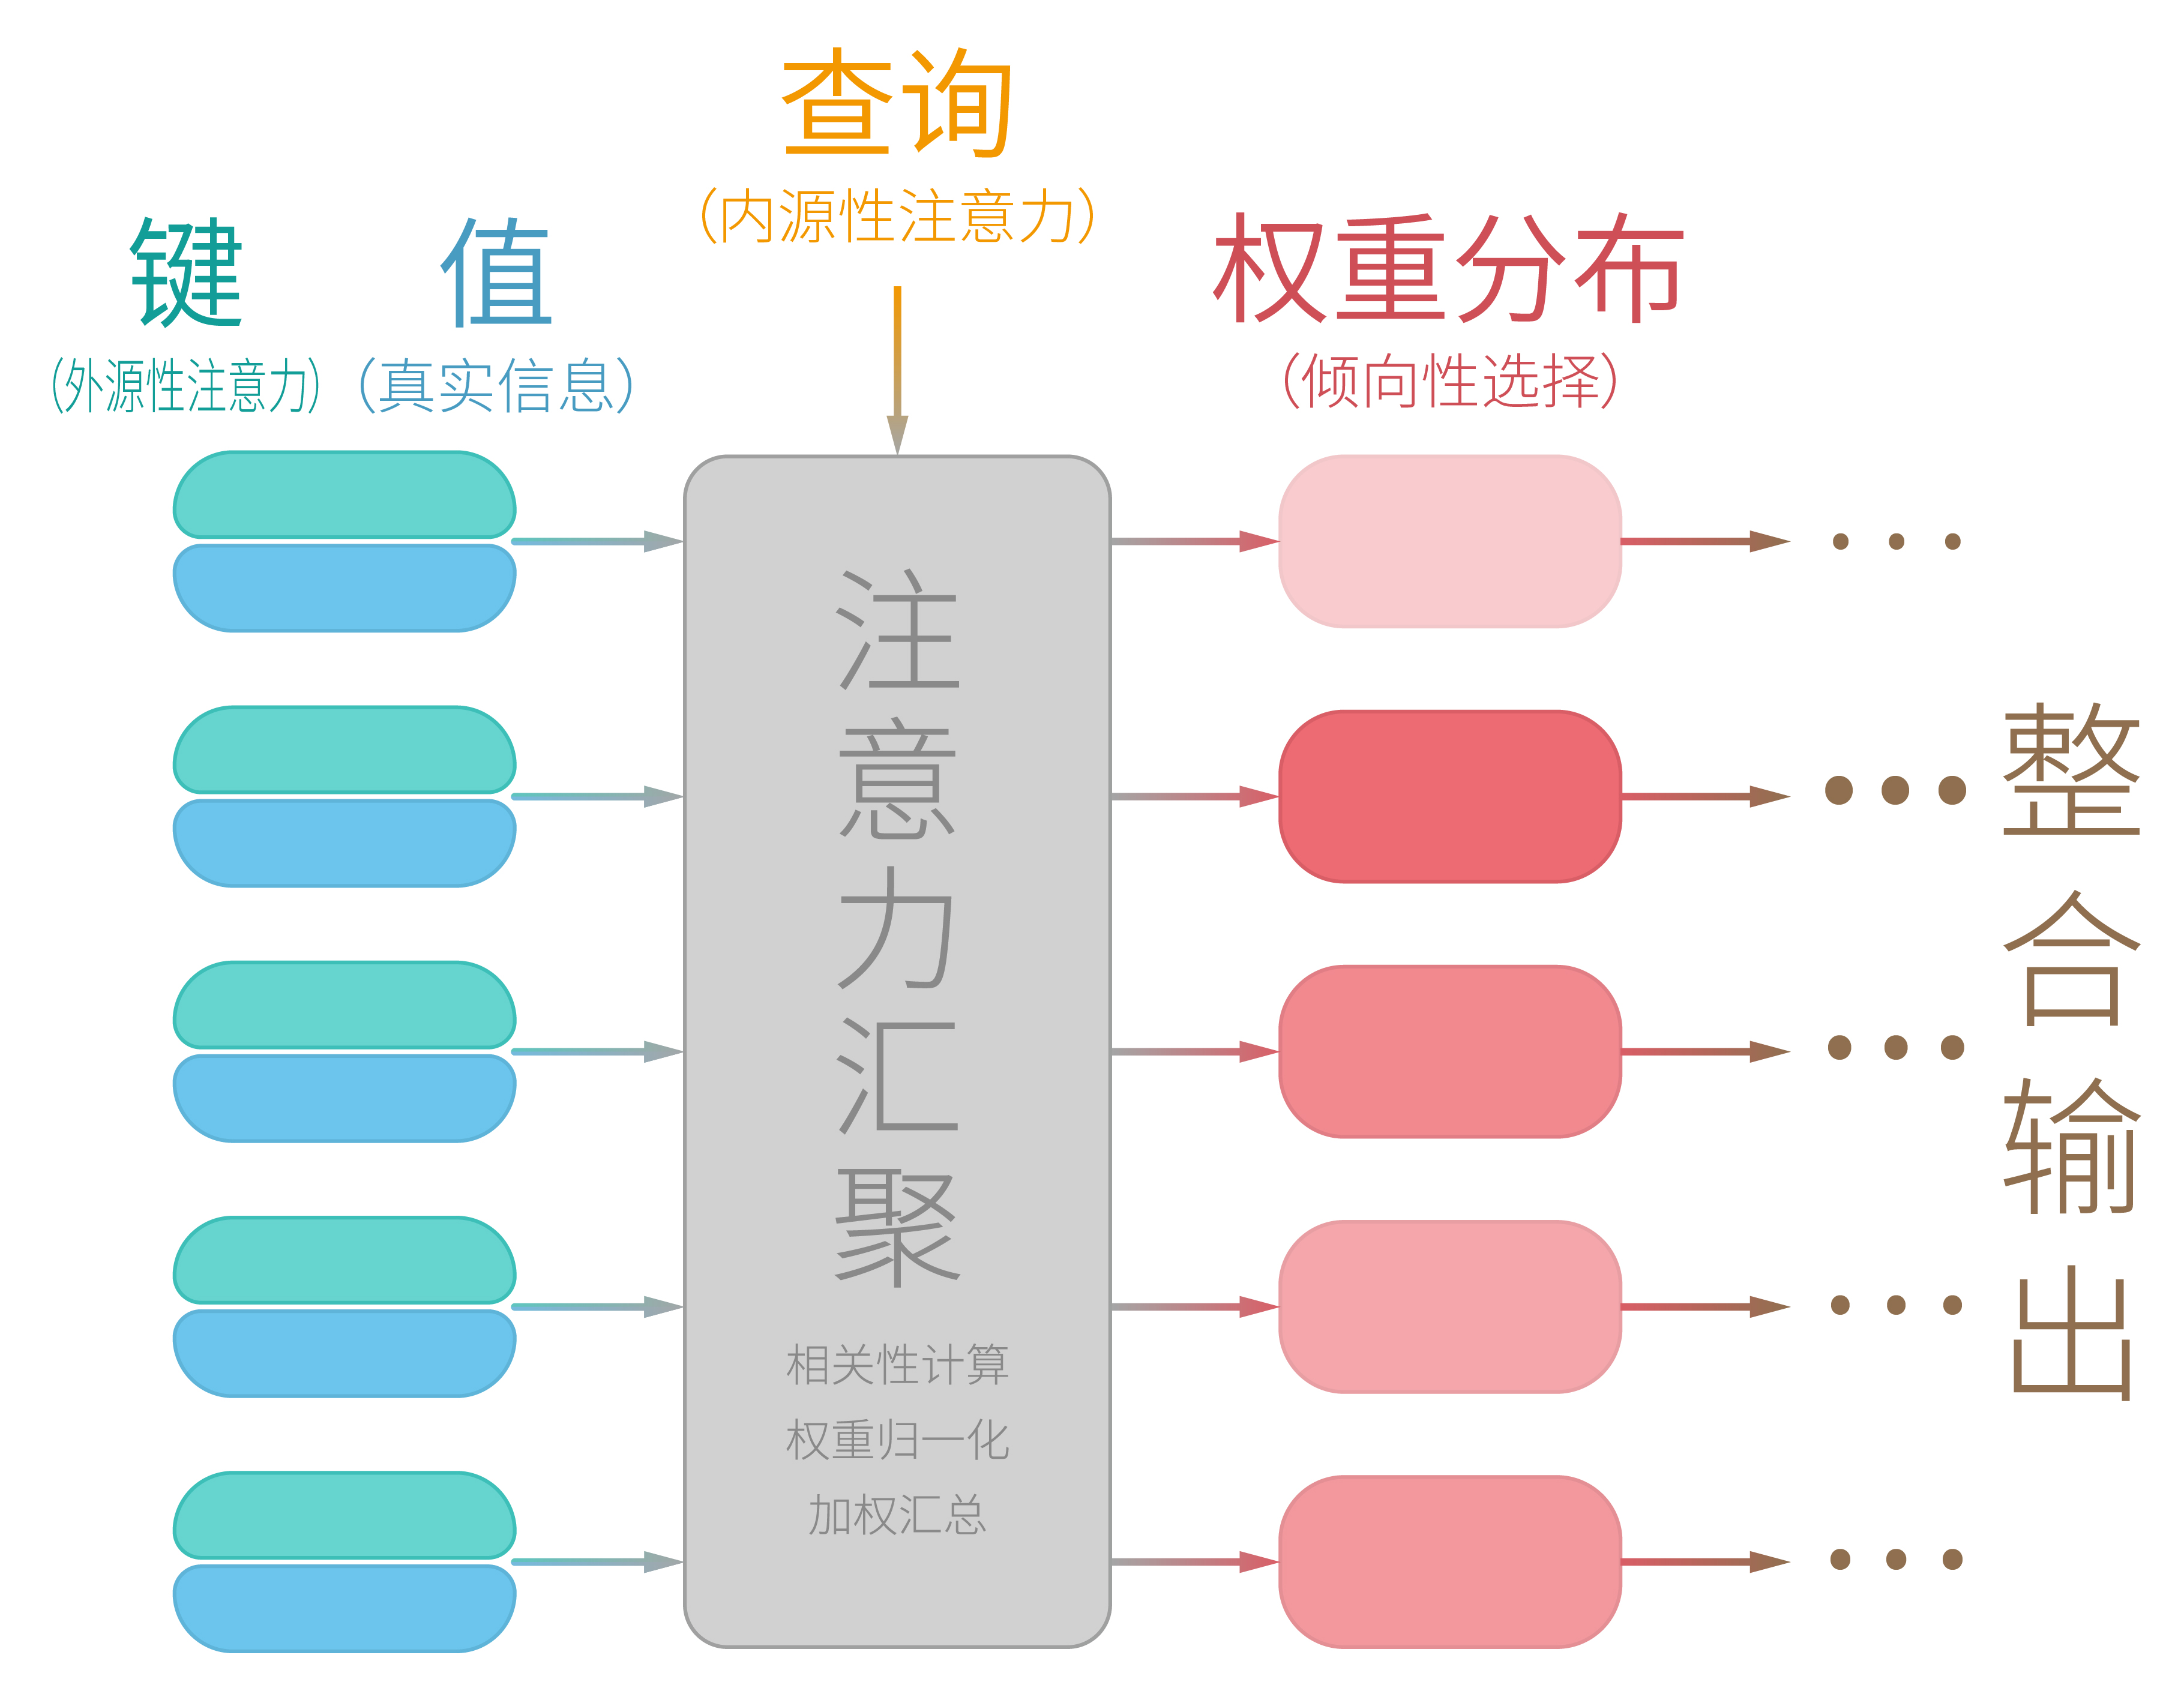

## 2. 数学框架：Q,K,V
### 2.1 如何理解?
想象你在图书馆找书：
- Q: 你的需求（如“找一本关于深度学习的书”）—— 目标
- K： 所有书的书名、作者、分类标签—— 可检索的线索
- V：每本书的具体内容——待提取的信息

### 2.2 Q,K,V的数学本质
#### 2.1 输入预处理
假设 输入序列为$mathbf{X} \in\mathbb{R}^{L \times d_{\text{model}}} $,通过三个权重矩阵生成：
，通过三个权重矩阵$ \mathbf{W}^Q, \mathbf{W}^K, \mathbf{W}^V \in \mathbb{R}^{d_{\text{model}} \times d_k}$生成：
$$
\begin{align*}
\mathbf{Q} &= \mathbf{X}\mathbf{W}^Q, \\
\mathbf{K} &= \mathbf{X}\mathbf{W}^K, \\
\mathbf{V} &= \mathbf{X}\mathbf{W}^V.
\end{align*}
$$

#### 2.2 注意力分数

**相似度计算**：反应目标与线索的匹配度
 - $\mathbf{Q}$ 和 $\mathbf{K}$ 计算每个位置的注意力分数

 $$\text{Score}(i, j) = \frac{\mathbf{Q}_i \cdot \mathbf{K}_j}{\sqrt{d_k}}$$

**Softmax归一化**：
$$
\alpha_{ij} = \text{Softmax}(\text{Score}(i, j))
$$

**加权聚合**
按权重整合$V$信息
$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \sum \alpha_{ij} \mathbf{V}_j
$$
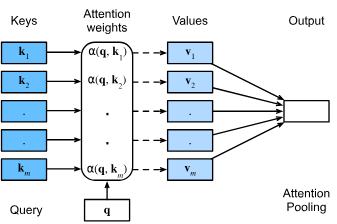

### 3. 注意力可视化

In [5]:
from typing import Optional,List,Union,Tuple
from matplotlib.pyplot import tight_layout,show,subplots
from numpy import ndarray
from seaborn import heatmap
from torch import Tensor

def plot_attention_heatmap(
        weights: Union[Tensor, ndarray],
        x_label: str = 'keys',
        y_label: str = 'Queries',
        title: Optional[Union[List[str], str]] = "Attention Weight",
        figsize: Tuple[float, float] = (8, 8),
):
    # 转换为NumPy数组（若为PyTorch张量）
    weights_np = weights.detach().cpu().numpy() if isinstance(weights, Tensor) else weights

    # 显式检查输入维度（至少4维）
    if weights_np.ndim < 4:
        raise ValueError(f"Expected weights with at least 4 dimensions, got {weights_np.ndim}")

    # 解包前四维（ax_row: 子图行数，ax_cols: 子图列数，H: 热力图高度，W: 热力图宽度）
    ax_row, ax_cols, H, W = weights_np.shape[:4]
    total_figsize = (figsize[1] * ax_row, figsize[0] * ax_cols)  # 总图幅大小

    # 创建子图（squeeze=False确保axes为二维数组）
    fig, axes = subplots(ax_row, ax_cols, figsize=total_figsize, squeeze=False)

    # 校验标题列表长度（若为列表）
    if isinstance(title, list):
        expected_length = ax_row * ax_cols
        if len(title) != expected_length:
            raise ValueError(f"Title list length ({len(title)}) must match number of subplots ({expected_length})")

    # 遍历所有子图
    for i in range(ax_row):
        for j in range(ax_cols):
            # 获取当前子图的标题
            current_title = title if isinstance(title, str) else title[i * ax_cols + j]

            # 获取热力图数据（二维矩阵）
            heatmap_data = weights_np[i, j, :, :]

            # 获取当前子图的轴对象
            ax = axes[i, j]

            # 绘制热力图
            heatmap(heatmap_data, ax=ax)

            # 设置标题和坐标轴标签
            ax.set_title(current_title)
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)

    # 调整子图间距并显示
    tight_layout()
    show()

In [ ]:
from numpy import random
import torch

# 测试1：形状 (1,1,12,23)（1行1列子图，热力图12x23）
weights1 = random.rand(1, 1, 12, 23)
plot_attention_heatmap(weights1, title="Test 1")

# 测试2：形状 (2,4,12,23)（2行4列子图，热力图12x23）
weights2 = random.rand(2, 4, 12, 23)
titles2 = [f'Head{i+1}' for i in range(weights2.shape[1])] * weights2.shape[0]  # 长度8，匹配2 * 4=8
plot_attention_heatmap(weights2, title=titles2, figsize=(12, 6))

# 测试3：形状 (1,1,10,10)（1行1列子图，热力图10x10）
weights3 = torch.eye(10).reshape(1, 1, 10, 10)
plot_attention_heatmap(weights3, title="Identity Matrix")

## 4.Nadaraya-Watson 核回归
### 4.1 核心思想
一种非参数回归方法，用于估计输入变量（特征）与连续输出变量（目标）之间的未知关系。其核心思想是“**局部加权平均**”：对于每个待预测点，仅利用其邻近的训练数据点，通过核函数赋予这些点不同的权重，最终用加权平均的方式预测该点的输出值。

传统参数回归（如线性回归、多项式回归）假设输入与输出之间存在某种固定形式的函数关系（如线性、二次），并通过最小化误差来拟合参数。但现实中，许多问题的真实关系可能高度复杂（非线性、非平稳），**参数模型难以准确描述**。此时，非参数回归方法（如核回归、局部加权散点图平滑）因不预设函数形式，能灵活捕捉数据的局部特征而被广泛使用。

是一种**静态的、无查询**的局部平滑。

### 4.2 数学形式：如何计算加权平均？

$$
\hat{f}(x) = \frac{ K\left( \frac{x - X_i}{h} \right) Y_i}{\sum_{i=1}^n K\left( \frac{x - X_i}{h} \right)}
$$
其中：
• $K(\cdot)$ 是核函数（Kernel Function），用于衡量数据点 $X_i$ 与目标点 $x$ 的“邻近程度”；

• $h > 0$ 是带宽（Bandwidth），控制核函数的宽度（即邻域的大小）；

• 分子是 $Y_i$ 的加权求和（权重由核函数决定），分母是权重的总和（用于归一化，确保 $\hat{f}(x)$ 是加权平均）。
### 4.3 核函数
- Gaussian Kernel :$K(u)=\frac{1}{\sqrt(2\pi)} e^-\frac{1}{2}u^2$

### 4.4 测试数据集
$$
y = 2 \sin(x) + x + \epsilon
$$

In [3]:
import torch
def f(x):
    return 2*torch.sin(x)+x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)

x_val = torch.arange(0,5,0.1)
y_val = f(x_val)

In [4]:
x_val

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])

In [5]:
def gaussian(x):
    return torch.exp(-torch.pow(x,2)/2)

In [6]:
def nadaraya_watson(x_train,y_train,x_val,kernel):
    # 广播机制 (N,1)-(1,M) --> (N,M)
    dists = x_train.reshape((-1,1)) - x_val.reshape((1,-1))
    k = kernel(dists).type(torch.float32)
    '''
    k.sum(0)：对核矩阵 k按列求和（dim=0），得到形状为 (1, M)的向量，其中每个元素是验证点 x[j]对应的所有训练点核值之和；
    k / k.sum(0)：对每个验证点 j，将其对应的所有训练点 i的核值 k[i,j]除以该列的和，使每个验证点的权重和为 1（归一化）；
    attention_w的形状为 (N, M)，其中 attention_w[i,j]表示训练点 x_train[i]对验证点 x_val[j]的贡献权重。
    '''
    attention_W = k/k.sum(0)
    # (N,)@(N,M)-->(M,)
    y_hat = y_train @ attention_W
    return y_hat,attention_W

In [7]:
import matplotlib.pyplot as plt
def plot_reg_compare(x_test,y_val,y_pred):
    plt.figure(figsize=(10,8))
    plt.plot(x_test,y_val,label='y')
    plt.scatter(x_test,y_pred,label='y_pred')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Regression Comparison')
    plt.tight_layout()
    plt.show()

In [ ]:
attention_W,y_hat = nadaraya_watson(x_train,y_train,x_val,kernel=gaussian)
plot_reg_compare(x_val,y_val,y_hat)
# unsqueeze(0) :(N,W)->(1,N,W)
plot_attention_heatmap(attention_W.unsqueeze(0).unsqueeze(0), x_label='K: Sorted training inputs',y_label="Q: Sorted testing inputs",title='Attention Weight')

### 4.4  参数化核回归
